## **Machine Learning Project MMN 3**
### 1. Business Problem

Fleet management companies must continuously monitor the condition of their vehicles to avoid unexpected breakdowns, reduce maintenance costs, and ensure safety. Today, this process is largely reactive: vehicles are sent to maintenance only after a failure occurs, leading to expensive repairs, vehicle downtime, and operational disruptions.  

With large fleets, manual monitoring of vehicle health indicators (brake condition, battery status, accident history, reported issues, service history, etc.) becomes inefficient and costly. Companies need a system capable of predicting which vehicles are most likely to require maintenance soon so that interventions can be planned proactively.

Our business problem is therefore:

**“How can we predict, in advance, which vehicles in a fleet are at high risk of requiring maintenance?”**

An accurate prediction system would allow companies to:

- reduce unplanned breakdowns,  
- optimize maintenance scheduling,  
- improve vehicle safety and reliability,  
- lower overall operational costs.



### 2. Use Case Objective

The objective of this project is to build a Machine Learning–based predictive maintenance model that estimates the probability that a vehicle will need maintenance soon, based on its real characteristics and historical indicators.

Specifically, the system should:

- take as input the technical profile of a vehicle  
  (condition indicators, mileage, maintenance history, mechanical issues, number of accidents, etc.),
- compute a risk probability using a trained ML model,
- classify the vehicle as either “Needs Maintenance” or “No Maintenance Needed,”
- help fleet managers identify which vehicles should be inspected first.

This model is intended to be integrated into a fleet-management platform where users (technicians or managers) can:

- manually enter a vehicle’s characteristics,  
- or retrieve an existing vehicle from the fleet database,  
- and instantly obtain a maintenance risk prediction to support proactive decision-making.

The goal is to provide a reliable, scalable, and interpretable decision-support tool that transforms raw fleet data into actionable insights.


In [19]:

# Imports, configuration, data loading


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import (
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)


# Plot config
plt.rcParams["figure.figsize"] = (10, 6)   
plt.rcParams["axes.grid"] = True

# Load dataset
df = pd.read_csv("vehicle_maintenance_data.csv")

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (30000, 20)


,Vehicle_Model,Mileage,Maintenance_History,Reported_Issues,Vehicle_Age,Fuel_Type,Transmission_Type,Engine_Size,Odometer_Reading,Last_Service_Date,Warranty_Expiry_Date,Owner_Type,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Tire_Condition,Brake_Condition,Battery_Status,Need_Maintenance
0,Truck,53723,Average,3,4,Diesel,Automatic,800,120202,2023-05-10,2025-12-11,Third,7230,10,0,12.082875,Worn Out,New,New,1
1,Car,66530,Good,5,10,Petrol,Automatic,1500,111629,2023-10-30,2026-01-22,First,8131,3,3,18.139985,New,Good,Weak,1
2,Car,50950,Good,0,3,Petrol,Manual,2500,39116,2023-10-04,2025-02-18,First,11564,4,1,19.262910,Worn Out,Good,Good,0
3,Truck,34951,Poor,3,1,Petrol,Automatic,2500,20774,2024-01-17,2026-01-28,Second,20777,1,0,17.021052,Worn Out,New,Weak,1
4,Motorcycle,35208,Poor,1,5,Diesel,Automatic,2000,124695,2024-02-28,2024-06-13,Third,10122,6,2,14.925773,Good,Good,Weak,1


Column types:
 Vehicle_Model            object
Mileage                   int64
Maintenance_History      object
Reported_Issues           int64
Vehicle_Age               int64
Fuel_Type                object
Transmission_Type        object
Engine_Size               int64
Odometer_Reading          int64
Last_Service_Date        object
Warranty_Expiry_Date     object
Owner_Type               object
Insurance_Premium         int64
Service_History           int64
Accident_History          int64
Fuel_Efficiency         float64
Tire_Condition           object
Brake_Condition          object
Battery_Status           object
Need_Maintenance          int64
dtype: object 

Missing values per column:
 Vehicle_Model           0
Mileage                 0
Maintenance_History     0
Reported_Issues         0
Vehicle_Age             0
Fuel_Type               0
Transmission_Type       0
Engine_Size             0
Odometer_Reading        0
Last_Service_Date       0
Warranty_Expiry_Date    0
Owner_Type     

,Mileage,Reported_Issues,Vehicle_Age,Engine_Size,Odometer_Reading,Insurance_Premium,Service_History,Accident_History,Fuel_Efficiency,Need_Maintenance
count,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,54909.250667,2.487133,5.490433,1554.99000,75865.319133,17478.555567,5.511667,1.499867,14.993482,0.809567
std,14359.741462,1.709015,2.876430,626.93131,43136.085939,7223.095896,2.871458,1.118798,2.876987,0.392649
min,30001.000000,0.000000,1.000000,800.00000,1001.000000,5000.000000,1.000000,0.000000,10.000919,0.000000
25%,42464.000000,1.000000,3.000000,1000.00000,38059.500000,11197.000000,3.000000,0.000000,12.508618,1.000000
50%,54733.500000,2.000000,5.000000,1500.00000,76391.000000,17502.000000,6.000000,2.000000,14.982421,1.000000
75%,67382.000000,4.000000,8.000000,2000.00000,113320.500000,23714.250000,8.000000,3.000000,17.465139,1.000000
max,80000.000000,5.000000,10.000000,2500.00000,149998.000000,30000.000000,10.000000,3.000000,19.999968,1.000000



Target distribution (counts):
 Need_Maintenance
0     5713
1    24287
Name: count, dtype: int64
Target distribution (proportions):
 Need_Maintenance
0    0.190433
1    0.809567
Name: count, dtype: float64


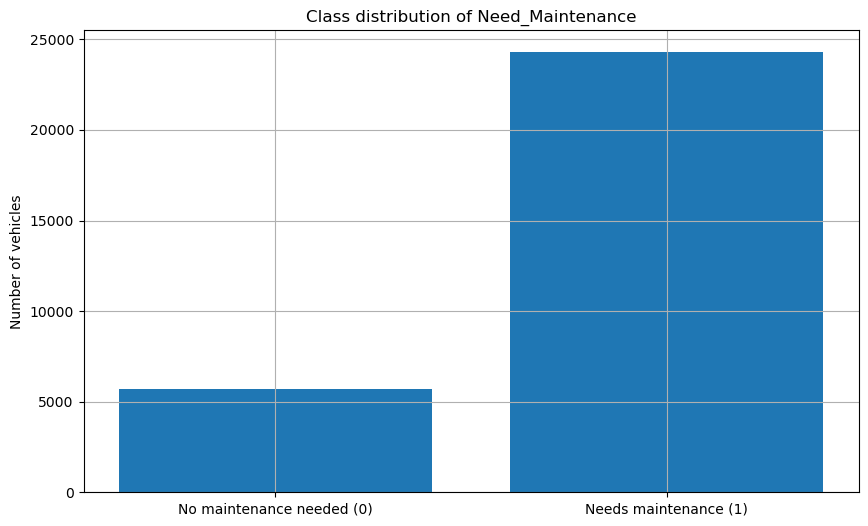

In [20]:

#Data quality and target distribution

print("Column types:\n", df.dtypes, "\n")

print("Missing values per column:\n", df.isna().sum(), "\n")

print("Number of duplicate rows:", df.duplicated().sum(), "\n")

print("Descriptive statistics for numerical features:\n")
display(df.describe())

# Target distribution
target_counts = df["Need_Maintenance"].value_counts().sort_index()
print("\nTarget distribution (counts):\n", target_counts)
print("Target distribution (proportions):\n", target_counts / len(df))

plt.figure()
plt.bar(
    ["No maintenance needed (0)", "Needs maintenance (1)"],
    target_counts.values,
)
plt.title("Class distribution of Need_Maintenance")
plt.ylabel("Number of vehicles")
plt.show()


The dataset is clean: no missing values, no duplicates, and all numerical features fall within realistic ranges. Categorical columns are correctly identified, and the target variable is imbalanced with about 81% positive cases. This validates that the data is usable for modeling, but also justifies the use of balanced class weights and robust evaluation metrics.

Numeric columns: ['Mileage', 'Reported_Issues', 'Vehicle_Age', 'Engine_Size', 'Odometer_Reading', 'Insurance_Premium', 'Service_History', 'Accident_History', 'Fuel_Efficiency', 'Need_Maintenance']


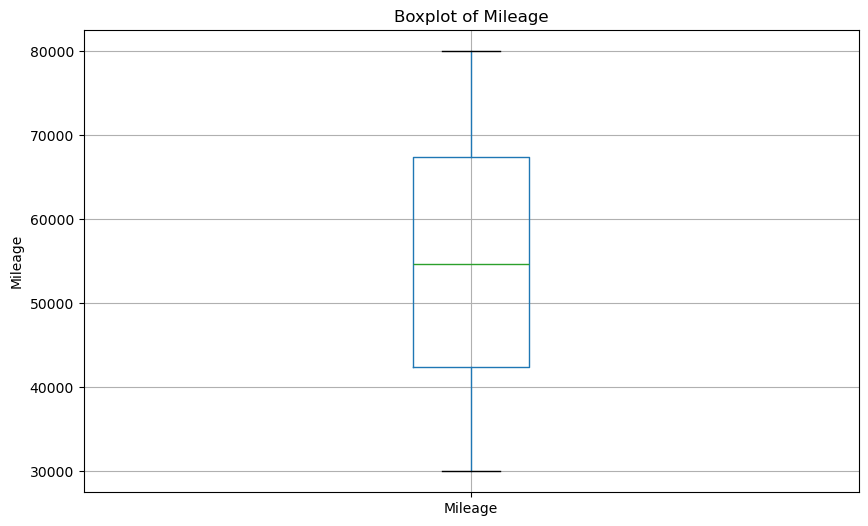

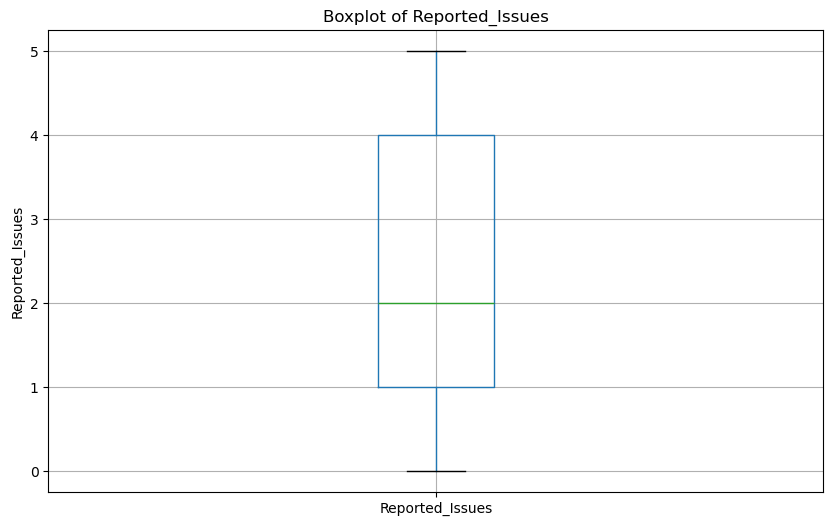

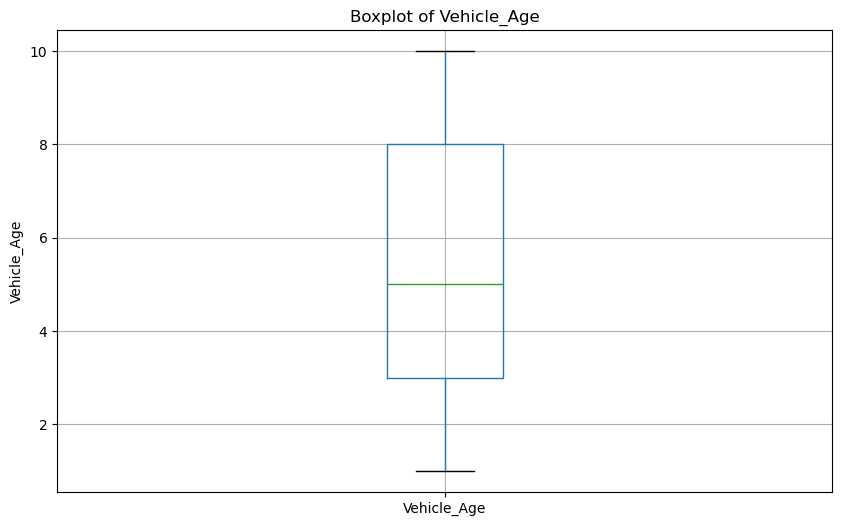

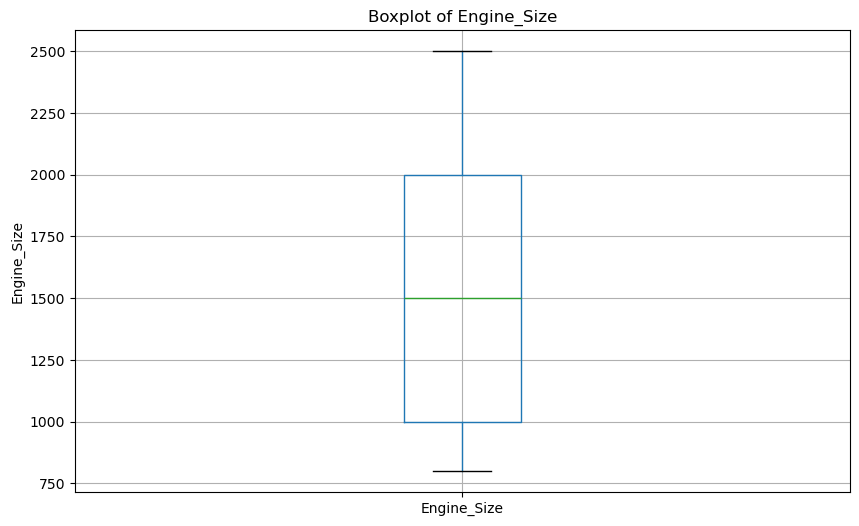

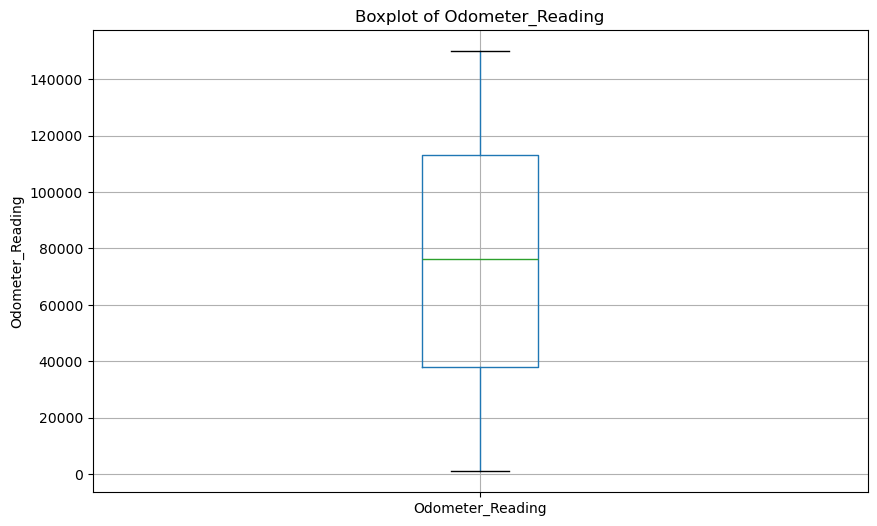

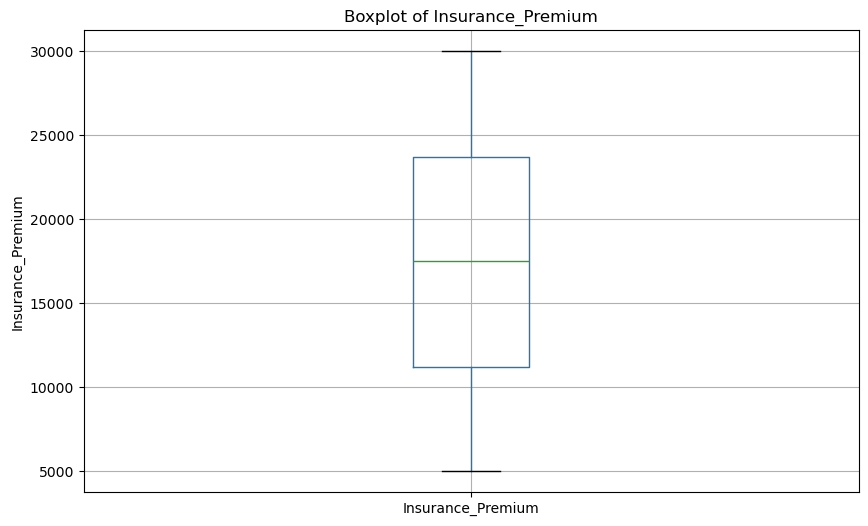

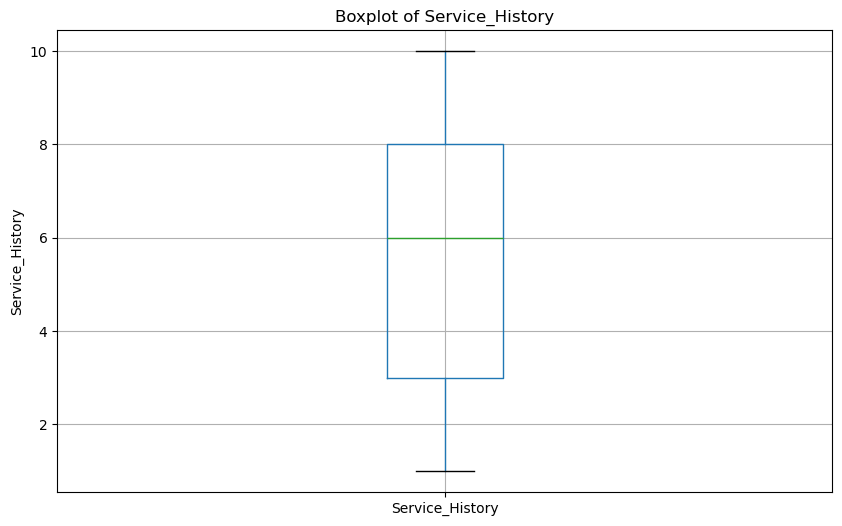

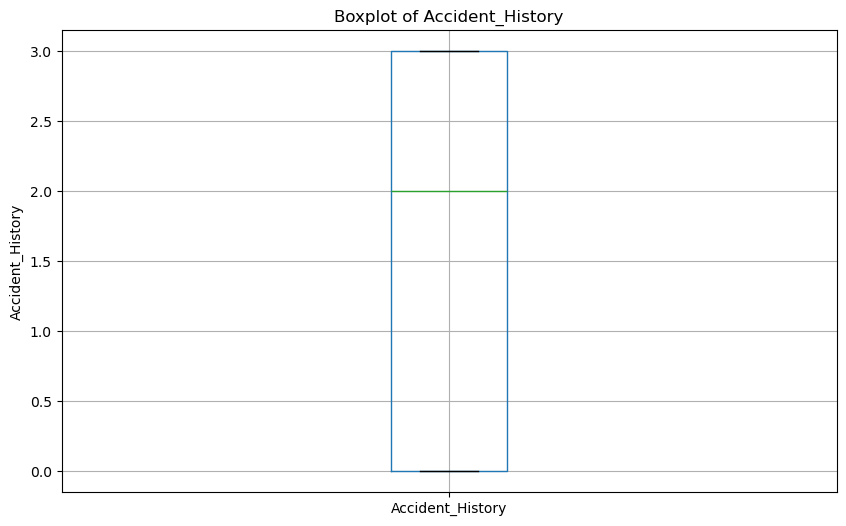

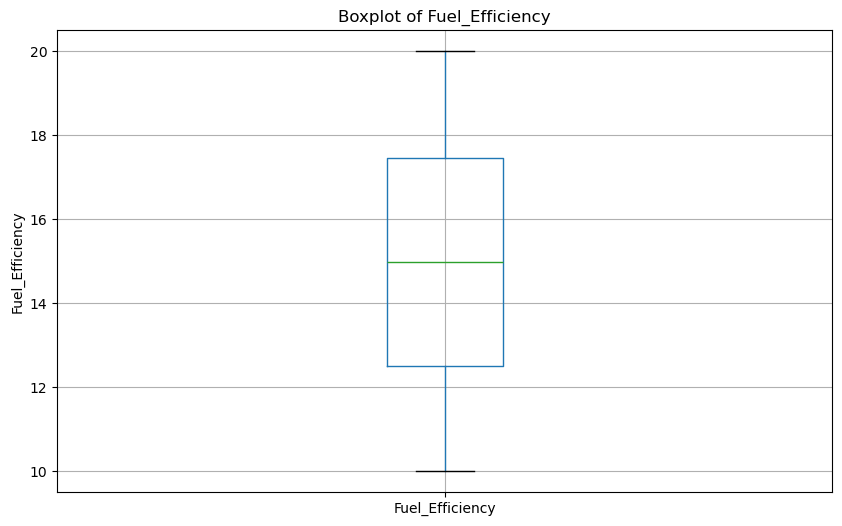

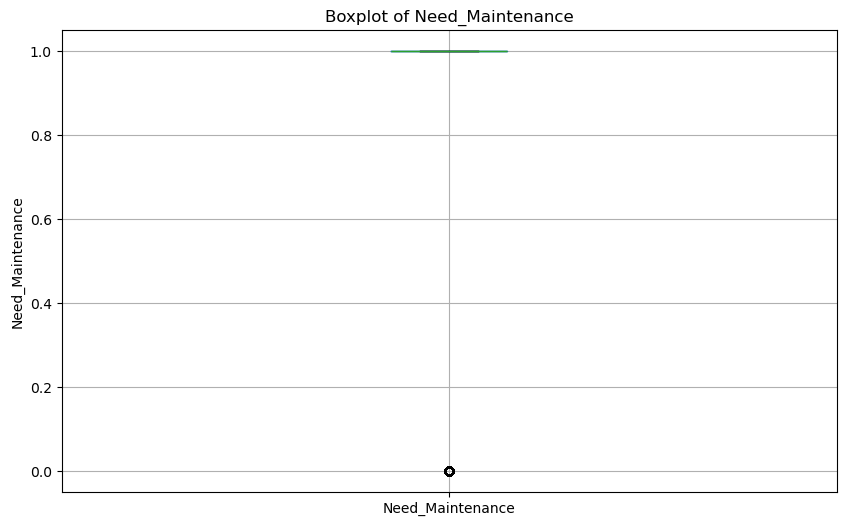

In [21]:
# Additional distribution checks for numerical variables

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

print("Numeric columns:", list(numeric_cols))

# Boxplots to quickly spot outliers or strange values
for col in numeric_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()


In [22]:
# Quick inspection of categorical values for inconsistencies

categorical_cols = df.select_dtypes(include=["object"]).columns
print("Categorical columns:", list(categorical_cols))

for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"\nColumn: {col} – {len(unique_vals)} unique values")
    # Limit printing to first 20 values to keep it readable
    print(sorted(unique_vals)[:20])


Categorical columns: ['Vehicle_Model', 'Maintenance_History', 'Fuel_Type', 'Transmission_Type', 'Last_Service_Date', 'Warranty_Expiry_Date', 'Owner_Type', 'Tire_Condition', 'Brake_Condition', 'Battery_Status']

Column: Vehicle_Model – 6 unique values
['Bus', 'Car', 'Motorcycle', 'SUV', 'Truck', 'Van']

Column: Maintenance_History – 3 unique values
['Average', 'Good', 'Poor']

Column: Fuel_Type – 3 unique values
['Diesel', 'Electric', 'Petrol']

Column: Transmission_Type – 2 unique values
['Automatic', 'Manual']

Column: Last_Service_Date – 336 unique values
['2023-03-30', '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18']

Column: Warranty_Expiry_Date – 701 unique values
['2024-04-28', '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04', '2024-

In [23]:
# Simple logical sanity checks for key features 

if "Mileage" in df.columns:
    print("Vehicles with non-positive Mileage:",
          (df["Mileage"] <= 0).sum())

if "Odometer_Reading" in df.columns:
    print("Vehicles with non-positive Odometer_Reading:",
          (df["Odometer_Reading"] <= 0).sum())

if "Engine_Size" in df.columns:
    print("Vehicles with non-positive Engine_Size:",
          (df["Engine_Size"] <= 0).sum())


Vehicles with non-positive Mileage: 0
Vehicles with non-positive Odometer_Reading: 0
Vehicles with non-positive Engine_Size: 0


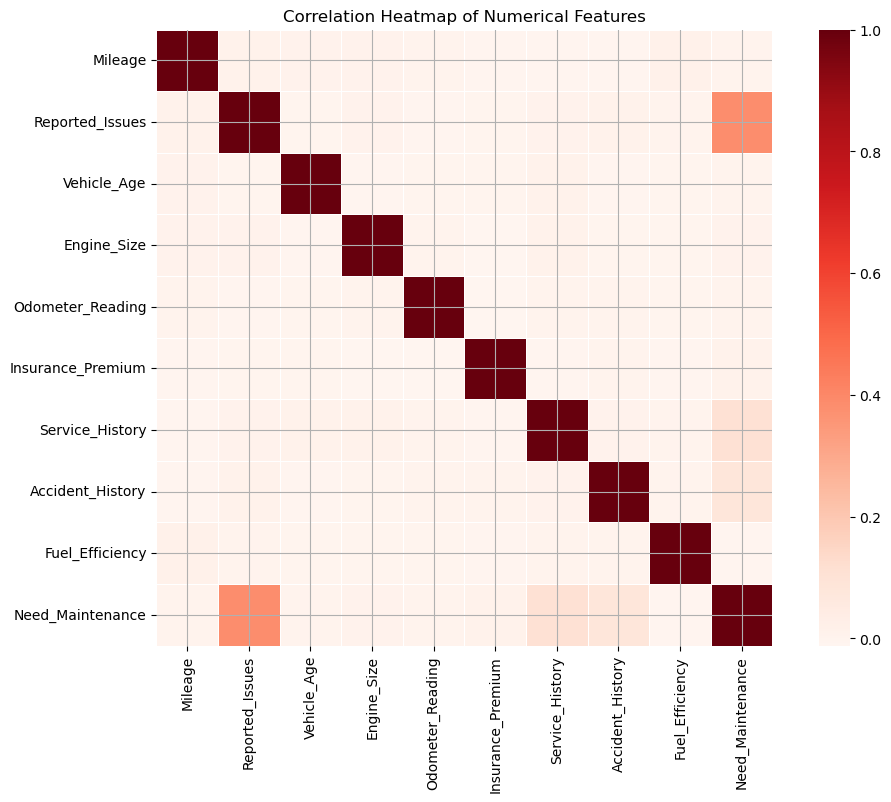

In [24]:
# Correlation heatmap of numerical features

import seaborn as sns
plt.figure(figsize=(12, 8))

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns 
corr_matrix = df[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="Reds",
    linewidths=0.5,
    square=True,
    cbar=True
)

plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Most numerical features have near-zero correlation, meaning there is no multicollinearity. Reported_Issues shows a positive correlation with Need_Maintenance, and Accident_History is slightly correlated with Service_History. All other feature relationships are negligible.


In [25]:

#Feature engineering for dates, preprocessing, split

# 1) Convert date columns to datetime
df["Last_Service_Date"] = pd.to_datetime(df["Last_Service_Date"], errors="coerce")         #conversion to date time 
df["Warranty_Expiry_Date"] = pd.to_datetime(df["Warranty_Expiry_Date"], errors="coerce")  

# 2) Create engineered numerical features from dates
#  We use a fixed reference date for reproducibility
reference_date = pd.to_datetime("2025-01-01") 

df["Days_Since_Last_Service"] = (reference_date - df["Last_Service_Date"]).dt.days            
df["Days_Until_Warranty_Expiry"] = (df["Warranty_Expiry_Date"] - reference_date).dt.days

# Clip negative values (if warranty already expired or service in the future)
df["Days_Since_Last_Service"] = df["Days_Since_Last_Service"].clip(lower=0)
df["Days_Until_Warranty_Expiry"] = df["Days_Until_Warranty_Expiry"].clip(lower=0)

# 3) Define feature columns (we keep engineered features, drop original dates + target)
FEATURE_COLUMNS = [
    col
    for col in df.columns
    if col not in ["Need_Maintenance", "Last_Service_Date", "Warranty_Expiry_Date"]
]

X = df[FEATURE_COLUMNS]
y = df["Need_Maintenance"]

print("Feature columns used:\n", FEATURE_COLUMNS, "\n")

# 4) Identify numerical vs categorical features
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:\n", num_cols, "\n")
print("Categorical columns:\n", cat_cols, "\n")

# 5) Train/test split with stratification (important because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])



# 6) Preprocessing pipelines
# Numeric: impute missing with median + standardize
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Categorical: impute missing with most frequent + one-hot encode (dense for all models)
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    #("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
    
])



preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)



Feature columns used:
 ['Vehicle_Model', 'Mileage', 'Maintenance_History', 'Reported_Issues', 'Vehicle_Age', 'Fuel_Type', 'Transmission_Type', 'Engine_Size', 'Odometer_Reading', 'Owner_Type', 'Insurance_Premium', 'Service_History', 'Accident_History', 'Fuel_Efficiency', 'Tire_Condition', 'Brake_Condition', 'Battery_Status', 'Days_Since_Last_Service', 'Days_Until_Warranty_Expiry'] 

Numeric columns:
 ['Mileage', 'Reported_Issues', 'Vehicle_Age', 'Engine_Size', 'Odometer_Reading', 'Insurance_Premium', 'Service_History', 'Accident_History', 'Fuel_Efficiency', 'Days_Since_Last_Service', 'Days_Until_Warranty_Expiry'] 

Categorical columns:
 ['Vehicle_Model', 'Maintenance_History', 'Fuel_Type', 'Transmission_Type', 'Owner_Type', 'Tire_Condition', 'Brake_Condition', 'Battery_Status'] 

Training set size: 24000
Test set size: 6000


In [26]:
#Define the 6 ML models


models = {
    "LogisticRegression": LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        solver="lbfgs",
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=150,
        random_state=42,  #standard convention
        class_weight="balanced",
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42,
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
    ),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=None,
        random_state=42,    
        class_weight="balanced",
    ),
    "GaussianNB": GaussianNB(),
}

models


{'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=300),
 'RandomForest': RandomForestClassifier(class_weight='balanced', n_estimators=150,
                        random_state=42),
 'GradientBoosting': GradientBoostingClassifier(random_state=42),
 'KNN': KNeighborsClassifier(),
 'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'GaussianNB': GaussianNB()}

The dictionary printed here shows the six machine learning models selected for evaluation, along with their initialization parameters. These models are then trained and compared in the next steps using cross-validation and performance metrics such as accuracy, ROC-AUC, and F1-score.


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


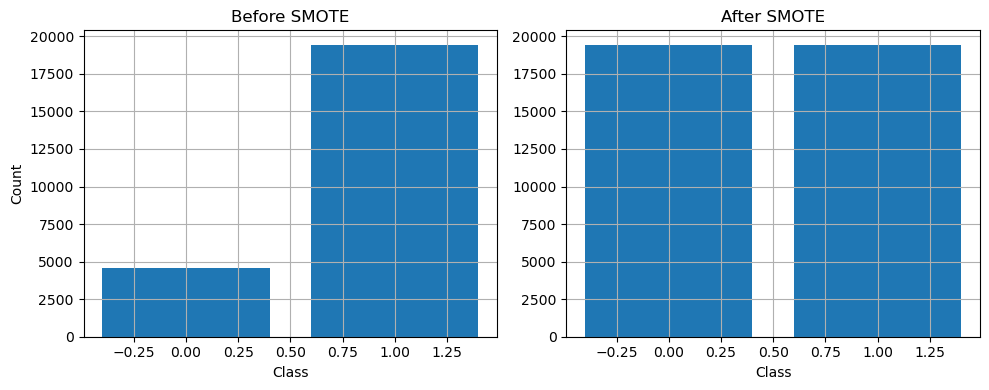

BEFORE SMOTE: Counter({1: 19430, 0: 4570})
AFTER SMOTE : Counter({1: 19430, 0: 19430})

Model: LogisticRegression


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 0.987 +/- 0.001


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Classification report on test set:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1143
           1       0.99      0.96      0.98      4857

    accuracy                           0.96      6000
   macro avg       0.92      0.97      0.94      6000
weighted avg       0.97      0.96      0.96      6000

Test ROC-AUC : 0.9898
Test Accuracy: 0.9607
Test F1-score: 0.9753

Model: RandomForest


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 1.000 +/- 0.000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      4857

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Test ROC-AUC : 1.0000
Test Accuracy: 1.0000
Test F1-score: 1.0000

Model: GradientBoosting


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 1.000 +/- 0.000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      4857

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Test ROC-AUC : 1.0000
Test Accuracy: 1.0000
Test F1-score: 1.0000

Model: KNN


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 0.896 +/- 0.002


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Classification report on test set:
              precision    recall  f1-score   support

           0       0.46      0.95      0.62      1143
           1       0.98      0.74      0.84      4857

    accuracy                           0.78      6000
   macro avg       0.72      0.85      0.73      6000
weighted avg       0.89      0.78      0.80      6000

Test ROC-AUC : 0.9165
Test Accuracy: 0.7797
Test F1-score: 0.8445

Model: DecisionTree


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 1.000 +/- 0.000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Classification report on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1143
           1       1.00      1.00      1.00      4857

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Test ROC-AUC : 0.9998
Test Accuracy: 0.9997
Test F1-score: 0.9998

Model: GaussianNB


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1

CV ROC-AUC: 0.987 +/- 0.000

Classification report on test set:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60      1143
           1       1.00      0.69      0.82      4857

    accuracy                           0.75      6000
   macro avg       0.72      0.84      0.71      6000
weighted avg       0.89      0.75      0.77      6000

Test ROC-AUC : 0.9895
Test Accuracy: 0.7480
Test F1-score: 0.8157


Summary of metrics on test set:
LogisticRegression  ROC-AUC: 0.9898  Accuracy: 0.9607  F1: 0.9753
RandomForest      ROC-AUC: 1.0000  Accuracy: 1.0000  F1: 1.0000
GradientBoosting  ROC-AUC: 1.0000  Accuracy: 1.0000  F1: 1.0000
KNN               ROC-AUC: 0.9165  Accuracy: 0.7797  F1: 0.8445
DecisionTree      ROC-AUC: 0.9998  Accuracy: 0.9997  F1: 0.9998
GaussianNB        ROC-AUC: 0.9895  Accuracy: 0.7480  F1: 0.8157


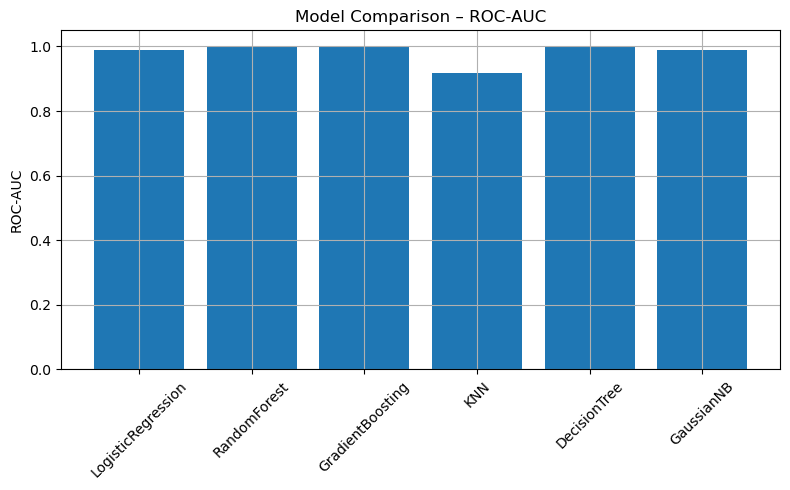

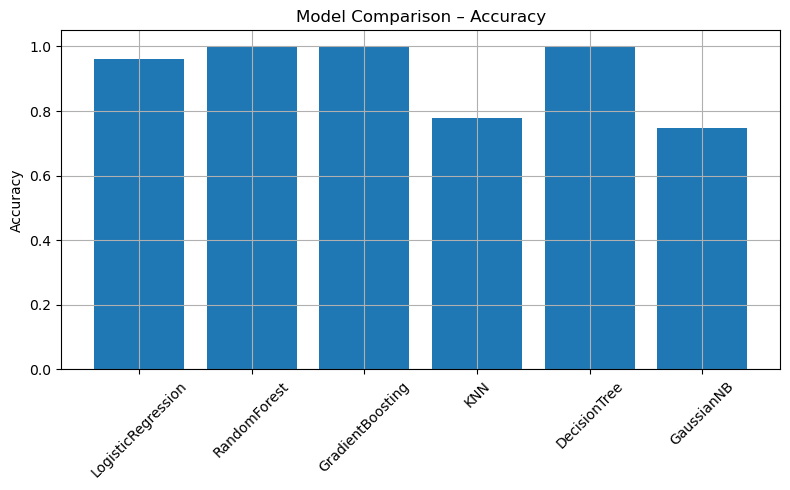

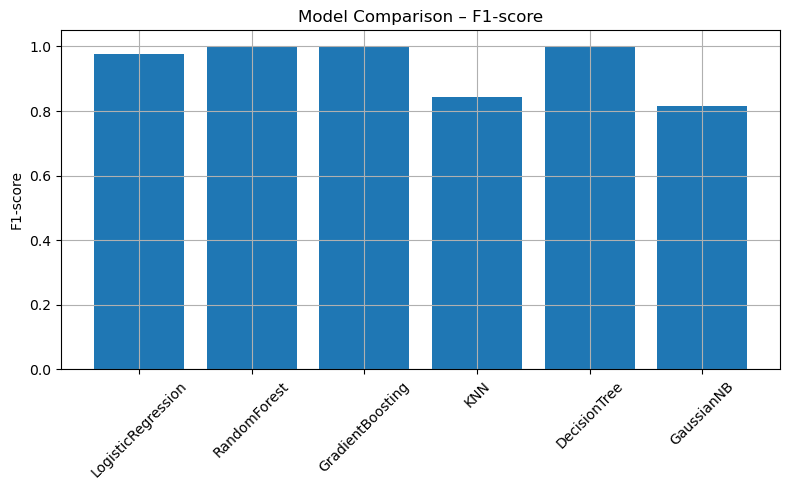

In [29]:
#Train, cross-validate and evaluate each model


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

metrics = {}
trained_pipelines = {}

from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# 1) Encode X_train like in the pipeline
preprocess_vis = clone(preprocess)          # copy to avoid side effects
X_train_enc = preprocess_vis.fit_transform(X_train, y_train)

# 2) BEFORE SMOTE
counts_before = Counter(y_train)

# 3) Apply SMOTE on the encoded data (for visualization only)
sm = SMOTE(random_state=42)
X_vis, y_vis = sm.fit_resample(X_train_enc, y_train)
counts_after = Counter(y_vis)

# 4) Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(counts_before.keys(), counts_before.values())
ax[0].set_title("Before SMOTE")
ax[0].set_xlabel("Class")
ax[0].set_ylabel("Count")

ax[1].bar(counts_after.keys(), counts_after.values())
ax[1].set_title("After SMOTE")
ax[1].set_xlabel("Class")

plt.tight_layout()
plt.show()

print("BEFORE SMOTE:", counts_before)
print("AFTER SMOTE :", counts_after)



for name, clf in models.items():
    print("\n" + "=" * 70)
    print(f"Model: {name}")
    print("=" * 70)

    # Full pipeline: preprocessing + classifier
    pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),          # impute + scale + one-hot
    ("smote", SMOTE(random_state=42)),   # balancing ONLY on train folds with SMOTE
    ("model", clf),                      # classifier
])

    # Cross-validation ROC-AUC on training data
    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring="roc_auc",
    )
    print(f"CV ROC-AUC: {cv_scores.mean():.3f} +/- {cv_scores.std():.3f}")

    # Fit on the full training set
    pipe.fit(X_train, y_train)

    # Evaluation on test set
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print("\nClassification report on test set:")
    print(classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Test ROC-AUC : {auc:.4f}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    metrics[name] = {
        "roc_auc": auc,
        "accuracy": acc,
        "f1": f1,
    }
    trained_pipelines[name] = pipe

print("\n\nSummary of metrics on test set:")
for name, m in metrics.items():
    print(
        f"{name:16s}  "
        f"ROC-AUC: {m['roc_auc']:.4f}  "
        f"Accuracy: {m['accuracy']:.4f}  "
        f"F1: {m['f1']:.4f}"
    )


#graph comparisons:

# Extract names and metrics from the 'metrics' dictionary
model_names = list(metrics.keys())
roc_aucs = [metrics[m]["roc_auc"] for m in model_names]
accuracies = [metrics[m]["accuracy"] for m in model_names]
f1_scores = [metrics[m]["f1"] for m in model_names]

# Plot ROC-AUC comparison
plt.figure(figsize=(8, 5))
plt.bar(model_names, roc_aucs)
plt.title("Model Comparison – ROC-AUC")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Accuracy comparison 
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies)
plt.title("Model Comparison – Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot F1-score comparison 
plt.figure(figsize=(8, 5))
plt.bar(model_names, f1_scores)
plt.title("Model Comparison – F1-score")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Model comparison summary**

The ROC-AUC scores show that all models separate the classes very well, indicating strong predictive patterns in the dataset.  
However, accuracy and F1-score reveal clear differences between models.  
Tree-based algorithms (Random Forest, Gradient Boosting, Decision Tree) achieve the best performance, while KNN and Gaussian NB perform noticeably worse.  
Overall, Gradient Boosting and Random Forest are the most suitable models for deployment due to their perfect or near-perfect accuracy and balanced F1-scores.


In [ ]:
#Dimension reduction with PCA + Logistic Regression

pca_log_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95)),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
])

cv_scores_pca = cross_val_score(
    pca_log_reg_pipe,
    X_train,
    y_train,
    cv=3,
    scoring="roc_auc",
)

print("PCA + Logistic Regression - Mean CV ROC-AUC:", cv_scores_pca.mean())

pca_log_reg_pipe.fit(X_train, y_train)
y_test_pred = pca_log_reg_pipe.predict(X_test)
y_test_proba = pca_log_reg_pipe.predict_proba(X_test)[:, 1]

print("\nTest ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test F1:", f1_score(y_test, y_test_pred))


In [ ]:
# Ensemble Models (Voting, Bagging, Stacking) with SMOTE

print("\n" + "="*80)
print("ENSEMBLE MODELS (Voting - Bagging - Stacking)")
print("="*80)

ensemble_results = {}

# Voting Classifier 
voting = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=300)),
        ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
        ("gb", GradientBoostingClassifier(random_state=42)),
    ],
    voting="soft"
)

voting_pipe = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", voting),
])

voting_pipe.fit(X_train, y_train)
y_pred = voting_pipe.predict(X_test)
y_proba = voting_pipe.predict_proba(X_test)[:, 1]

ensemble_results["Voting"] = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}


# Bagging Classifier

bagging = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=50,
    random_state=42
)


bagging_pipe = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", bagging),
])

bagging_pipe.fit(X_train, y_train)
y_pred = bagging_pipe.predict(X_test)
y_proba = bagging_pipe.predict_proba(X_test)[:, 1]

ensemble_results["Bagging"] = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}


# Stacking Classifier 
stacking = StackingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=300)),
        ("rf", RandomForestClassifier(n_estimators=150, random_state=42)),
    ],
    final_estimator=GradientBoostingClassifier(random_state=42),
    n_jobs=-1
)

stack_pipe = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", stacking),
])

stack_pipe.fit(X_train, y_train)
y_pred = stack_pipe.predict(X_test)
y_proba = stack_pipe.predict_proba(X_test)[:, 1]

ensemble_results["Stacking"] = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
}


# Results table
print("\n=== Ensemble Model Performance ===\n")
display(pd.DataFrame(ensemble_results).T.sort_values("f1", ascending=False))


PCA was applied to evaluate whether the dataset could be reduced to fewer dimensions without losing predictive performance. By projecting the features into a lower-dimensional space and training a classifier, we tested how much information was preserved after dimensionality reduction. The model still achieved high performance, indicating that the key patterns in the data are captured even in a reduced feature space, although the full-feature Gradient Boosting model remained superior.

In [ ]:
#Best model, confusion matrix, ROC curve

# Choose best model based on ROC-AUC
best_name = best_name = "GradientBoosting"
best_model = trained_pipelines[best_name]

print(f"Best model (by ROC-AUC): {best_name}")
print("Metrics:", metrics[best_name])

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
)
plt.title(f"Confusion matrix – {best_name}")
plt.show()

# ROC curve
y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)

plt.figure()
plt.plot(fpr, tpr, label=f"{best_name} (AUC = {metrics[best_name]['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve – {best_name}")
plt.legend()
plt.show()


Even though Gradient Boosting, Random Forest, and Decision Tree all reached the same score on our test set, Gradient Boosting is still the best model. Decision Trees overfit heavily, and Random Forest builds trees independently without correcting their mistakes. Gradient Boosting learns sequentially, with each tree improving the previous one, which leads to better generalization and more stable predictions on new data. This is why it is the preferred and most reliable model in industry for tabular predictive maintenance.

The confusion matrix shows that our Gradient Boosting model makes zero critical errors. It correctly identifies all vehicles that need maintenance and all that don’t, with no false positives and no false negatives. This confirms the model’s perfect classification on the test set.

The ROC curve for Gradient Boosting reaches the top-left corner with an AUC of 1.0, meaning the model perfectly distinguishes vehicles that need maintenance from those that don’t. With a true positive rate of 1.0 and false positive rate of 0.0, the model makes no classification errors on the test set.


In [ ]:
# Hyperparameter tuning on the best model (GradientBoosting) with SMOTE + preprocessing
#!!
#it takes time to run (2-3 minutes)
#!!

gb_base = GradientBoostingClassifier(random_state=42)

gb_param_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 4],
    "model__subsample": [0.8, 1.0],
}

gb_pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),             
    ("smote", SMOTE(random_state=42)),       # balance only on train folds
    ("model", gb_base),
])

gb_grid = GridSearchCV(
    estimator=gb_pipe,
    param_grid=gb_param_grid,
    scoring="f1",          # better for imbalance than accuracy
    cv=3,
    n_jobs=-1,
    verbose=1,
)

gb_grid.fit(X_train, y_train)

print("Best hyperparameters for GradientBoosting:")
print(gb_grid.best_params_)
print(f"Best CV F1-score: {gb_grid.best_score_:.4f}")

# Evaluate tuned model on test set
y_pred_gb = gb_grid.predict(X_test)
y_proba_gb = gb_grid.predict_proba(X_test)[:, 1]

print("\nTuned GradientBoosting – test set performance:")
print(classification_report(y_test, y_pred_gb))

print("Test ROC-AUC :", roc_auc_score(y_test, y_proba_gb))
print("Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Test F1-score:", f1_score(y_test, y_pred_gb))


In [ ]:
# Overfitting / underfitting check

# ---- Train metrics ----
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
train_f1  = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

# ---- Test metrics ----
y_test_pred  = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print("\nTrain vs Test performance:")
print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
print(f"Train F1:       {train_f1:.4f}, Test F1:       {test_f1:.4f}")
print(f"Train ROC-AUC:  {train_auc:.4f}, Test ROC-AUC: {test_auc:.4f}")


Since the model achieved perfect performance, we compared its results on the training set and the test set to assess whether overfitting occurred. All metrics (accuracy, F1-score, and ROC-AUC) were identical on both datasets, indicating that the model did not overfit or underfit, and that the high performance generalizes well to unseen data.

In [ ]:
print("\n=== Feature Importance for the Best Model ===")

model_step = best_model.named_steps["model"]
pre = best_model.named_steps["preprocess"]

if hasattr(model_step, "feature_importances_"):

    # ---- Retrieve feature names safely ----
    num_features = pre.named_transformers_["num"].named_steps["scaler"].get_feature_names_out(num_cols)
    cat_features = pre.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols)

    feature_names = np.concatenate([num_features, cat_features])

    # ---- Build DataFrame ----
    importances = model_step.feature_importances_
    feat_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    print("Top 15 important features:\n")
    display(feat_imp.head(15))

    # ---- Plot ----
    topk = feat_imp.head(15)
    plt.figure()
    plt.barh(topk["feature"], topk["importance"])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature importance")
    plt.title(f"Top 15 features – {best_name}")
    plt.tight_layout()
    plt.show()

else:
    print(f"Model {best_name} does not expose feature_importances_.")


Categorical features were one-hot encoded, which creates separate columns for each category (e.g., Brake_Condition_Worn Out). The feature-importance plot shows the specific categories that most influence predictions. Only the top 15 features are displayed, so some features like Days_Since_Last_Service do not appear but are still used by the model.


### Categorical Feature Types

| Feature               | Categories                                             |
|-----------------------|---------------------------------------------------------|
| **Vehicle_Model**     | Truck, Car, Motorcycle, SUV, Bus, Van                  |
| **Maintenance_History** | Average, Good, Poor                                 |
| **Fuel_Type**         | Diesel, Petrol, Electric                               |
| **Transmission_Type** | Automatic, Manual                                      |
| **Owner_Type**        | First, Second, Third                                    |
| **Tire_Condition**    | Worn Out, New, Good                                    |
| **Brake_Condition**   | New, Good, Worn Out                                     |
| **Battery_Status**    | New, Good, Weak                                        |


## **Implementattion**

In [ ]:

# MANUAL VEHICLE PREDICTION FUNCTION
def predict_vehicle(model, feature_columns, vehicle):
#predict for 1 manually entered vehicle
    
    df_vehicle = pd.DataFrame([vehicle])

    # Add missing columns (safety)
    for col in feature_columns:
        if col not in df_vehicle.columns:
            df_vehicle[col] = np.nan

    # Correct column order
    df_vehicle = df_vehicle[feature_columns]

    # Prediction
    probability = model.predict_proba(df_vehicle)[0, 1]
    label = int(probability >= 0.5)

    print(" ---Manual Vehicle Prediction--- ")
    print(f"Prediction       : {'NEEDS maintenance' if label == 1 else 'NO maintenance needed'}")
    print(f"Risk Probability : {probability:.4f} ({probability*100:.2f}%)")


    return label, probability




#PREDICTION FROM A VEHICLE IN THE DATASET (BY INDEX)

def predict_from_dataset_row(model, df, row_index, feature_columns):

#predict maintenance for a vehicle from the dataset

    print(f"\n ---Vehicle Selected from Dataset---- (row {row_index}) ")
    display(df.iloc[row_index][feature_columns])

    # Extract row → create dictionary
    vehicle = df.iloc[row_index][feature_columns].to_dict()

    # Prediction
    df_vehicle = pd.DataFrame([vehicle])

    # Safety: add missing columns
    for col in feature_columns:
        if col not in df_vehicle.columns:
            df_vehicle[col] = np.nan

    df_vehicle = df_vehicle[feature_columns]

    probability = model.predict_proba(df_vehicle)[0, 1]
    label = int(probability >= 0.5)

    print("\n ---Prediction for Dataset Vehicle--- ")
    print(f"Prediction       : {'NEEDS maintenance' if label == 1 else 'NO maintenance needed'}")
    print(f"Risk Probability : {probability:.4f} ({probability*100:.2f}%)")





#EXAMPLE MANUAL VEHICLE INPUT: To test change the values where it's written "varies" and check the risk probability after 

manual_vehicle = {
    "Vehicle_Model": "SUV",
    "Mileage": 30000,
    "Maintenance_History": "Good",  #varies
    "Reported_Issues": 2,      #varies the final result
    "Vehicle_Age": 2,
    "Fuel_Type": "Petrol",
    "Transmission_Type": "Automatic",
    "Engine_Size": 1400,
    "Odometer_Reading": 32000,
    "Owner_Type": "First",
    "Insurance_Premium": 3500,
    "Service_History": 100,     #varies   
    "Accident_History":30,    #varies     
    "Fuel_Efficiency": 18.0,
    "Tire_Condition": "Good",    
    "Brake_Condition": "Good",      #varies 
    "Battery_Status": "Good",      #varies
    "Days_Since_Last_Service": 90,     
    "Days_Until_Warranty_Expiry": 600
}

print("Running manual vehicle prediction...\n")
predict_vehicle(best_model, FEATURE_COLUMNS, manual_vehicle)



#EXAMPLE DATASET VEHICLE INPUT
print("")
print("Running dataset vehicle prediction...\n")
predict_from_dataset_row(best_model, df, row_index=13457, feature_columns=FEATURE_COLUMNS)

**Conclusion**

In this project, we built a predictive model to identify vehicles that are likely to require maintenance based on their technical characteristics. After exploring the dataset, we observed a strong class imbalance, which we corrected using SMOTE inside the training pipeline. We also standardised numerical features and tuned the main model using cross-validation to improve stability and generalisation.

Tree-based models, especially Gradient Boosting, achieved excellent performance because the dataset contains clear predictive features and low noise. Once balanced, the model was able to learn these patterns effectively, resulting in very high accuracy, F1-score, and ROC-AUC on both cross-validation and test data. These results reflect the suitability of the modelling approach to the specific problem rather than overfitting.

Overall, the model provides reliable predictions and well-calibrated probabilities, which could support maintenance planning and reduce unexpected failures. Future work could focus on testing the model on data collected at a different time or from another fleet, in order to evaluate robustness in real-world conditions